# Enduro setup

### Roms Download

Es posible que al generar su ambiente el código falle porque la librería *atary_py* no tiene los roms descargados.

En ese caso pueden descargar los roms ejecutando la siguiente celda.

In [ ]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null#
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null

# > /dev/null omits command output

--2021-06-28 22:17:30--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.2’

Roms.rar.2           77%[==============>     ]   8.26M   469KB/s    eta 6s     ^C


Would you like to replace the existing file HC ROMS.zip
11826711 bytes, modified on 2019-12-22 11:24
with a new one
11826711 bytes, modified on 2019-12-22 11:24

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A
replace ROMS/128 in 1 Game Select ROM (128 in 1) (Unknown) ~.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Parte 1: Implementación 🚀

## Actividad 1

Se utilizan los últimos 4 pasos como input para que la red juegue, ya que un solo frame no tiene suficiente información para que la red sepa que acción realizar, además permite reconocer un movimiento específico como que el auto va avanzando o retrocediendo.

## Gym environment

In [ ]:
import gym
from gym import spaces
import cv2

"""
Esta función lo que hace es recibir un frame y luego pasarlo a escala de grises,
después recorta la imágen y la redimensiona a una matriz de 84,84 que entrará a 
la CNN. """
def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

Un wrapper permite modificar el ambiente de juego original e incorporar el pre-procesamiento.

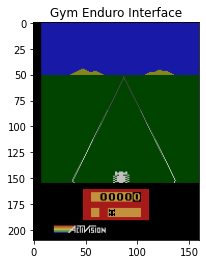

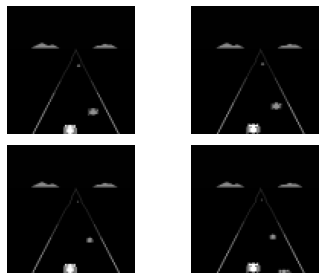

(4, 84, 84)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4)

# For reproducibility
seed = 0
env.seed(seed)

obs = env.reset()

# squeeze remueve todas las columnas de largo 1 de un nparray
# por lo tanto el siguiente snippet solo deja el frame y 
# elimina los otros atributos
plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env)
env = FrameStack(env,num_stack=4)
obs = env.reset()

for _ in range(100):
  action = random.randint(0,env.action_space.n-1)
  obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print(obs.shape)


### Replay buffer

Almacenar la experiencia adquirida durante el juego

In [ ]:
from collections import deque

class ReplayMemory(object):

    def __init__(self, capacity, input_shape=4*84*84):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

        self.memory_counter = 0

    def push(self, state, action, next_state, reward, done):
        """Saves a transition.
        e.g. ('state', 'action', 'next_state', 'reward','done')
        """
        self.memory.append((state, action, reward, next_state, done))
          

    def sample(self, batch_size):
      """ Samples a transition with a defined batch size"""
      samples = random.sample(self.memory, batch_size)
      
      states, actions, rewards, next_states, dones = zip(*samples)

      return (np.asarray(states),
              actions,
              np.asarray(rewards),
              np.asarray(next_states),
              np.asarray(dones))
       
    def __len__(self):
        return len(self.memory)

## Actividad 2: implementación


### Dueling DQN Model

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)

        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):

        batch_size = x.size(0)
        
        # forward pass red convolucional
        features = self.conv(x)

        # dejamos 32 tensores planos de 7*7*64
        features = features.view(batch_size, -1)
        
        # forward pass rama fully-connected para V(s)
        val = self.relu(self.fc1_adv(features))
        val = self.fc2_adv(val).expand(batch_size, self.num_actions)

        # forward pass rama fully-connected para A(s,a)
        adv = self.relu(self.fc1_adv(features))
        adv = self.fc2_adv(adv)

        # Calculo de Q(s,a) a partir de ecuacion (4)
        Q_values = val + adv - adv.mean(1).unsqueeze(1).expand(batch_size, self.num_actions)
      
        return Q_values
        
    def feature_size(self):
        return self.conv(torch.autograd.Variable(torch.zeros(32, 4, 84, 84))).size()

### Training

Para guardar sus modelos y resultados les recomiendo montar su drive

In [ ]:
from google.colab import drive # importamos la función para montar el drive 
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
root = "/content/gdrive/MyDrive/Deep Learning/Tarea 3/"

In [ ]:
import json

import joblib

# En este archivo se guardará el estado actual de entrenamiento
replay_filename = "replay_memory.json"
state_filename = "trainning_state_copy.joblib"

with open(root + "trainning_state.joblib", "r") as fp:
  states = json.load(fp)

reward_history = states['reward_history']
initial_step = states['total_steps']

In [ ]:
import torch.optim as optim
import os
from tqdm import tqdm
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

replay_buffer_size=500_000
batch_size = 32
gamma = 0.99 # Discounted return
learning_starts = 50000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se ejecuta una propagación error (loss) en la red
frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
target_update_freq=10000 # Frecuencia en que se actualizan los pesos de la red target
LR = 0.00025 # Tasa de aprendizaje

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device)
Q_target = Dueling_DQN(in_channels, num_actions).to(device)

# Optimizador, pueden elegir entre Adam o RMSProp
optimizer = torch.optim.RMSprop(Q.parameters(), lr = LR)

# Criterio de pérdida
criterion = nn.MSELoss()

# Creamos nuestra memoria de estados
replay_memory = ReplayMemory(replay_buffer_size)

LOG_EVERY_N_STEPS = 50_000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 250_000 # Pasos por época
N_EPOCHS = 20 # Número de épocas

def exploration(t):
    h = 1 - (t/1_111_111)
    if h < 0.1:
      return 0.1
    else:
      return h

# Load checkpoint
if os.path.exists(root + "Q_state"):
  Q.load_state_dict(torch.load(root + "Q_state"))
  Q_target.load_state_dict(torch.load(root + "Q_target_state"))
total_steps = initial_step
# initial_epoch = (int)(initial_step/STEPS_PER_EPOCH)

reward_history = []
# Reseteamos nuestro ambiente para empezar el entrenamiento
last_obs = env.reset()

max_reward = 0

for epoch in tqdm(range(9, N_EPOCHS),position=0,leave=True):
  accumulated_reward = []
  total_reward = 0
  print(20*"=", "EPOCH ", epoch, 20*"=")
  for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
      #1. before learning starts, choose actions randomly
      if total_steps < learning_starts:
          action = np.random.randint(num_actions)
      else:
          # epsilon greedy exploration
          sample = random.random()
          # la funcion exploration permite calcular el threshold para la política e-greedy
          threshold = exploration(total_steps) 
          if sample > threshold:
              # Esto hace que la red esté en modo Eval (aumenta la eficiencia)
              with torch.no_grad():
                # Calculo de la acción con la red Q
                state = torch.FloatTensor(np.array([last_obs])/255).to(device)
                qs = Q.forward(state)
                action = torch.argmax(qs).item()
          else:
              action = np.random.randint(num_actions)

      obs, reward, done, info = env.step(action)
      total_reward += reward

      replay_memory.push(last_obs, action, obs, reward, done)
      if done:
        obs = env.reset()
        # Guardar reward acumulado del episodio en una lista o tupla
        accumulated_reward.append(total_reward)
        total_reward = 0

      # update last_obs
      last_obs = obs


      ### 2. Perform experience replay and train the network.
      if (total_steps > learning_starts + initial_step  and total_steps % learning_freq == 0):
        obs_t, act_t, rew_t, next_obs, done_mask = replay_memory.sample(batch_size)
        
        # Pasar los arreglos a tensores y al device actual
        # No olviden normalizar sus tensores de entrada (pasar los frames a floats entre 0 y 1) lo cual se hace dividiendo el tensor por 255
        obs_t = torch.Tensor(obs_t/255).to(device)
        act_t = torch.from_numpy(np.array(act_t, dtype=np.int64)).to(device)
        rew_t = torch.Tensor(rew_t).to(device)
        next_obs = torch.Tensor(next_obs/255).to(device)
        # TODO: pasar a tensor porsiaca
        # done_mask = np.done_mask)

        # input batches to networks
        q_values = Q.forward(obs_t).gather(1, act_t.unsqueeze(1))
        q_values = q_values.squeeze(1)


        # Loss calculation
        with torch.no_grad():
          q_values_next = Q_target.forward(next_obs)
        
        q_values_next = torch.max(q_values_next, dim=1)[0]

        # Todos los casos en que haya terminado el juego el valor de la acción vale cero
        q_values_next[done_mask] = 0.0

        # Calculamos el valor esperado de q
        q_expected = rew_t + gamma * q_values_next 

        # criterion: MSE
        loss = criterion(q_values, q_expected)

        # backwards pass
        optimizer.zero_grad()

        loss.backward()
        # update
        optimizer.step()

        # Actualizar pesos de red target (cada target_update_freq actualizaciones de los parámetros de Q)
        if total_steps % target_update_freq*4 == 0:
            Q_target.load_state_dict(Q.state_dict())

      total_steps += 1
    
      if t % LOG_EVERY_N_STEPS == 0 and t != 0:
          """
          Mostrar resultados actuales
          e.g. Mejor reward y promedio de ultimos 100 episodios
          entre otros.
          """
          epoch_max_reward= np.max(accumulated_reward)
          max_reward = max([epoch_max_reward, max_reward])
          mean_reward = np.mean(accumulated_reward[-100:])
          print(f"Best reward: {max_reward}; Promedio de los últimos 100 episodios: {mean_reward} ")

  """
  Guardar modelo y resultados!
  """
  epoch_max_reward= np.max(accumulated_reward)
  max_reward = max([epoch_max_reward, max_reward])
  mean_reward = np.mean(accumulated_reward[-100:])
  reward_history.append((max_reward, mean_reward))
  torch.save(Q.state_dict(), root + "Q_state")
  torch.save(Q_target.state_dict(), root + "Q_target_state")
  print(f"Best reward: {max_reward}; Promedio de los últimos 100 episodios: {mean_reward} ")
  json_obj = json.dumps({"total_steps": total_steps, "reward_history": reward_history, "loss": loss.item()})
  with open(root + state_filename, "w") as outfile:
      outfile.write(json_obj)

  0%|          | 49/250000 [00:00<08:38, 481.79it/s]

==================== EPOCH  9 ====================


 20%|█▉        | 49987/250000 [01:37<06:37, 503.76it/s]

Best reward: 337.0; Promedio de los últimos 100 episodios: 176.53846153846155 


 40%|████      | 100020/250000 [06:24<14:22, 173.87it/s]

Best reward: 389.0; Promedio de los últimos 100 episodios: 186.8 


 60%|██████    | 150021/250000 [11:10<09:55, 167.91it/s]

Best reward: 389.0; Promedio de los últimos 100 episodios: 197.75 


 80%|████████  | 200019/250000 [16:01<04:53, 170.54it/s]

Best reward: 411.0; Promedio de los últimos 100 episodios: 201.5744680851064 


  0%|          | 17/250000 [00:00<27:35, 151.01it/s]

Best reward: 451.0; Promedio de los últimos 100 episodios: 193.43103448275863 
==================== EPOCH  10 ====================


 20%|██        | 50030/250000 [05:04<19:53, 167.48it/s]

Best reward: 481.0; Promedio de los últimos 100 episodios: 282.9 


 40%|████      | 100021/250000 [10:08<15:21, 162.76it/s]

Best reward: 481.0; Promedio de los últimos 100 episodios: 221.17391304347825 


 60%|██████    | 150016/250000 [15:11<09:59, 166.87it/s]

Best reward: 481.0; Promedio de los últimos 100 episodios: 231.90625 


 80%|████████  | 200023/250000 [20:16<05:08, 162.21it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 260.5 


  0%|          | 16/250000 [00:00<26:28, 157.39it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 272.3333333333333 
==================== EPOCH  11 ====================


 20%|██        | 50020/250000 [05:09<19:58, 166.85it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 314.6666666666667 


 40%|████      | 100019/250000 [10:18<15:30, 161.22it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 309.1111111111111 


 60%|██████    | 150031/250000 [15:27<10:24, 160.18it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 310.5925925925926 


 80%|████████  | 200019/250000 [20:36<05:07, 162.43it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 306.3243243243243 


  0%|          | 16/250000 [00:00<26:21, 158.06it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 287.625 
==================== EPOCH  12 ====================


 20%|██        | 50025/250000 [05:08<21:40, 153.82it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 138.66666666666666 


 40%|████      | 100027/250000 [10:18<15:20, 162.89it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 209.95454545454547 


 60%|██████    | 150027/250000 [15:27<10:15, 162.41it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 212.76470588235293 


 80%|████████  | 200020/250000 [20:36<05:06, 162.87it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 241.92857142857142 


  0%|          | 17/250000 [00:00<27:34, 151.09it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 271.44897959183675 
==================== EPOCH  13 ====================


 20%|██        | 50026/250000 [04:58<19:40, 169.36it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 232.45454545454547 


 40%|████      | 100022/250000 [09:57<15:04, 165.80it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 263.85 


 60%|██████    | 150028/250000 [14:59<09:59, 166.80it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 257.741935483871 


 80%|████████  | 200021/250000 [20:02<05:03, 164.45it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 275.7435897435897 


  0%|          | 17/250000 [00:00<27:10, 153.36it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 278.3541666666667 
==================== EPOCH  14 ====================


 20%|██        | 50032/250000 [05:03<20:00, 166.53it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 184.5 


 40%|████      | 100029/250000 [10:00<13:45, 181.62it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 189.2173913043478 


 60%|██████    | 150029/250000 [14:37<09:05, 183.35it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 210.47058823529412 


 80%|████████  | 200035/250000 [19:16<04:43, 176.54it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 204.45652173913044 


  0%|          | 15/250000 [00:00<28:16, 147.39it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 215.55357142857142 
==================== EPOCH  15 ====================


 20%|██        | 50037/250000 [04:37<17:56, 185.77it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 294.1111111111111 


 40%|████      | 100037/250000 [09:13<13:35, 183.82it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 284.89473684210526 


 60%|██████    | 150029/250000 [13:50<08:51, 188.01it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 277.2413793103448 


 80%|████████  | 200021/250000 [18:22<04:27, 186.81it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 279.97435897435895 


100%|██████████| 250000/250000 [22:58<00:00, 181.33it/s]


Best reward: 728.0; Promedio de los últimos 100 episodios: 276.0 


  0%|          | 17/250000 [00:00<25:33, 163.02it/s]

==================== EPOCH  16 ====================


 20%|██        | 50029/250000 [04:37<18:33, 179.61it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 275.77777777777777 


 40%|████      | 100027/250000 [09:13<14:23, 173.68it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 322.11764705882354 


 60%|██████    | 150033/250000 [13:49<08:54, 186.97it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 286.51724137931035 


 80%|████████  | 200037/250000 [18:26<04:30, 184.71it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 269.0 


  0%|          | 17/250000 [00:00<25:31, 163.24it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 290.8085106382979 
==================== EPOCH  17 ====================


 20%|██        | 50021/250000 [04:34<18:14, 182.71it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 276.77777777777777 


 40%|████      | 100021/250000 [09:14<13:46, 181.37it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 305.3888888888889 


 60%|██████    | 150029/250000 [13:55<09:17, 179.42it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 306.5357142857143 


 80%|████████  | 200020/250000 [18:41<04:42, 176.91it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 281.64102564102564 


  0%|          | 16/250000 [00:00<26:18, 158.35it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 283.7551020408163 
==================== EPOCH  18 ====================


 20%|██        | 50021/250000 [04:53<19:49, 168.17it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 212.91666666666666 


 40%|████      | 100024/250000 [09:46<14:35, 171.31it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 239.6086956521739 


 60%|██████    | 150034/250000 [14:40<10:19, 161.48it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 248.625 


 80%|████████  | 200032/250000 [19:33<04:50, 171.81it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 253.41860465116278 


  0%|          | 17/250000 [00:00<27:33, 151.22it/s]

Best reward: 728.0; Promedio de los últimos 100 episodios: 276.76 
==================== EPOCH  19 ====================


 20%|██        | 50029/250000 [04:56<20:54, 159.43it/s]

Best reward: 789.0; Promedio de los últimos 100 episodios: 425.5 


 40%|████      | 100022/250000 [10:00<15:33, 160.64it/s]

Best reward: 789.0; Promedio de los últimos 100 episodios: 297.2631578947368 


 60%|██████    | 150024/250000 [15:04<10:05, 165.07it/s]

Best reward: 789.0; Promedio de los últimos 100 episodios: 326.9259259259259 


 80%|████████  | 200034/250000 [20:05<05:06, 163.17it/s]

Best reward: 789.0; Promedio de los últimos 100 episodios: 323.94594594594594 


100%|██████████| 11/11 [4:26:02<00:00, 1451.16s/it]

Best reward: 789.0; Promedio de los últimos 100 episodios: 312.6304347826087 


In [ ]:

reward_history
reward_history2 = states['reward_history'] + reward_history
with open(root + "reward_history.json", "w") as outfile:
    json.dump(reward_history2, outfile)

# Parte 2: Detalles 📌



### Actividad 3

* El principal beneficio que tiene la arquitectura Dueling DQN, es que este tipo de red puede aprender que estados son importantes tomar una acción, por ejemplo, en que estados puede haber una colisión inminente y cuales estados no son relevantes, de esta forma la red sabe con mayor precisión que estados son los más importantes y permite que la red aprenda de una forma más eficiente.

* Este beneficio se ve reflejado en el juego Enduro, ya que hay muchos casos en que el auto puede ir en cualquier parte de la autopista y no necesita tomar ninguna acción específica, por lo tanto, la red aprende a distingir los estados importantes y luego a partir de estos tomar una acción adecuada.

### Actividad 4

* Un buffer de memoria mejora la eficiencia del aprendizaje, ya que permite extraer de manera aleatoria mini batches, los que no tienen una correlación y por ende, hay más posibilidad de que aprendan algo util y no solamente un recorrido lineal.

* La estrategia e-greedy comienza con un valor grande, ya que al comienzo la red aun no logra aprender nada y lo más probable es que elija la misma acción siempre, por lo tanto, es mejor explorar opciones nuevas a través de acciones random y, a partir de estas, descubrir nuevos estados que le entregan más información a la red al momento del entrenamiento.

## Actividad 5

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_actions)

        self.relu = nn.ReLU()

In [ ]:
dqn = DQN(4, 9)
dueling = Dueling_DQN(4, 9)

In [ ]:
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("dueling: ", num_trainable_parameters(dueling))
print("dqn: ", num_trainable_parameters(dqn))

dueling:  3295402
dqn:  1688745


In [ ]:
3295402-1688745

1606657

El modelo utilizado tiene 3.295.402 parámetros entrenables, mientras que el otro modelo tiene tan solo 1.688.745 parámetros. Esto quiere decir que hay una diferencia de 1.606.657 parámetros entrenables entre ambos modelos.

### Actividad 6

Algunos de los hiperparámetros utilizados para implementar el modelo son:

**Tasa de aprendizaje:** 0.00025

**Optimizador:** RMSprop

**Función de perdida:** MSE

**Batch Size:** 32

**Replay Buffer Size:** 500.000

**Frecuencia de actualización de pesos para Q Target:** 40.000

**Número de Épocas:** 20

**Pasos por época:** 250.000


# Parte 3: Resultados 🔎


Graficar promedio de últimos 100 episodios de cada época

In [ ]:
import json

with open(root + "reward_history.json", "r") as outfile:
    reward_history = json.load(outfile)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_best_acc(history, epochs=20):
  x = np.linspace(1, epochs, epochs)
  plt.plot(x, history, label='Reward máximo') 
  plt.xlabel('Épocas')
  plt.ylabel('Mejor reward')
  plt.title("Evolución del reward máximo")
  plt.legend()

def plot_mean_acc(history, epochs=20):
  x = np.linspace(1, epochs, epochs)
  plt.plot(x, history, label='Reward promedio') 
  plt.xlabel('Épocas')
  plt.ylabel('Reward promedio')
  plt.title("Evolución del reward promedio de los últimos 100 episodios de cada época")
  plt.legend()

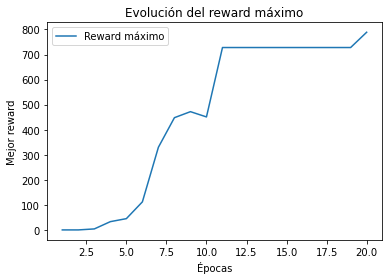

In [ ]:
a, b = zip(*reward_history)
plot_best_acc(a)

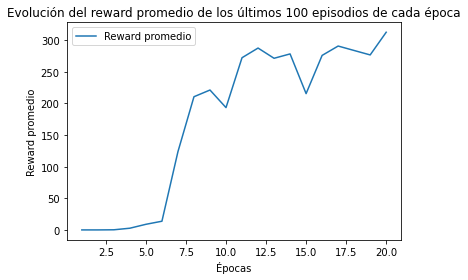

In [ ]:
plot_mean_acc(b)

# Testing (Opcional)

Si lo desean, pueden visualizar como su red juega enduro.
Una manera de hacerlo es guardar los *frames* de un episodio en una lista y luego visualizarlos como GIF.

Un resultado de red entrenada se puede ver a continuación

In [ ]:
frames = []
max_reward = 0

reward_accumulation = 0
for step in range(30_000):
    # Esto hace que la red esté en modo Eval (aumenta la eficiencia)
    with torch.no_grad():
      # Calculo de la acción con la red Q
      state = torch.FloatTensor(np.array([last_obs])/255).to(device)
      qs = Q_target.forward(state)
      action = torch.argmax(qs).item()

    obs, reward, done, info = env.step(action)
    reward_accumulation += reward

    frames.append(obs[0])

    if done:
      obs = env.reset()
      print("Perdimos con reward: ", reward_accumulation)
      reward_accumulation = 0

    last_obs = obs

Perdimos con reward:  208.0
Perdimos con reward:  467.0
Perdimos con reward:  661.0
Perdimos con reward:  801.0


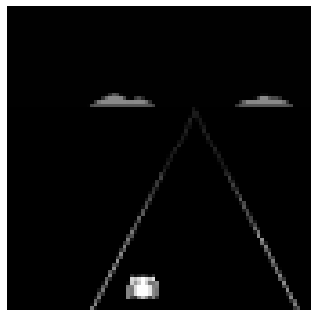

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

frames_show = frames[-1000:]

plt.figure(figsize=(frames_show[0].shape[1] / 15.0, frames_show[0].shape[0] / 15.0), dpi = 72)
patch = plt.imshow(frames_show[0],cmap='gray')
plt.axis('off')
animate = lambda i: patch.set_data(frames_show[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_show), interval = 100)
HTML(ani.to_jshtml())